In [1]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
import folium
from folium import plugins
from folium.features import DivIcon
from matplotlib.patches import Circle
from html2image import Html2Image

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# load data
prod22 = pd.read_csv('Data/brewery_production_2022_interpolated.csv')
sales = pd.read_csv('Data/Sales/TTB_QuarterlyBeerStateStatisticalReleases.csv')

# remove null total counts
prod22_complete = prod22.loc[~prod22['total_annual'].isnull()].copy()

# geographic data paths
districts = 'Data/Geographic/legislative_districts.geojson'
wa = 'Data/Geographic/WA_State_Boundary.geojson'

In [3]:
# set theme

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# figure sizes (horizontal/vertical/square)
figsize_v = (6,10)
figsize_h = (10,6)

### Sales

In [4]:
sales.head(6)

Year  TotalTaxableRemovalBarrels  BottlesCans       Kegs  PintsGrowlers  \
0  2017                   489065.42    158040.31  231441.72       99583.39   
1  2018                   556941.42    189497.15  229886.01      137558.26   
2  2019                   577035.83    203429.70  214666.06      158940.07   
3  2020                   493922.99    264939.38  104965.55      124018.06   
4  2021                   556285.34    263117.80  148269.29      144898.25   
5  2022                   559227.67    246682.98  165168.49      147376.20   

   PercentBottleCans  PercentKegs  PercentPintsGrowlers  
0              0.323        0.473                 0.204  
1              0.340        0.413                 0.247  
2              0.353        0.372                 0.275  
3              0.536        0.213                 0.251  
4              0.473        0.267                 0.260  
5              0.441        0.295                 0.264

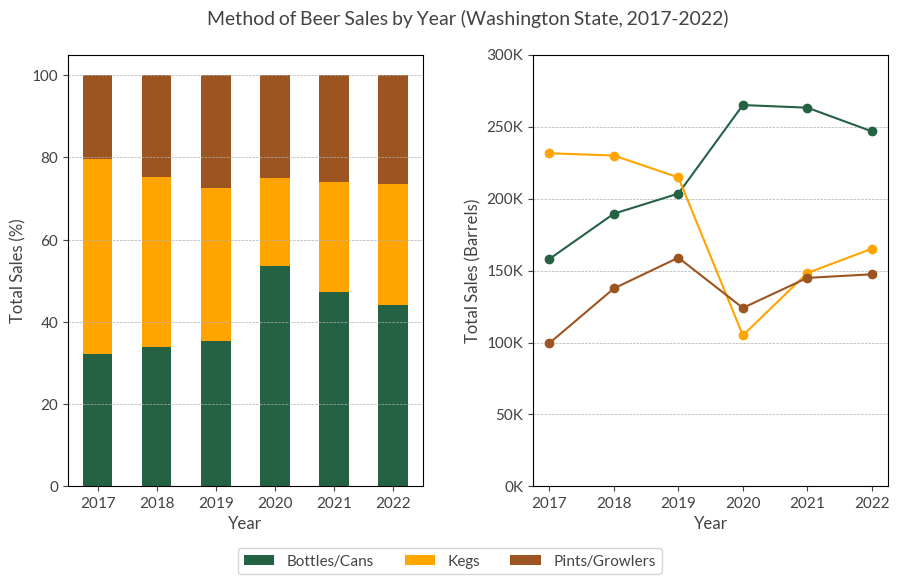

In [5]:
# data
sales['PercentBottleCans100'] = sales['PercentBottleCans'] * 100
sales['PercentKegs100'] = sales['PercentKegs'] * 100
sales['PercentPintsGrowlers100'] = sales['PercentPintsGrowlers'] * 100
sales_sub = sales[['Year', 'PercentBottleCans100','PercentKegs100','PercentPintsGrowlers100']]
sales_sub = sales_sub.rename(columns={'PercentBottleCans100': 'Bottles/Cans', 'PercentKegs100':'Kegs',
                                      'PercentPintsGrowlers100': 'Pints/Growlers'}) 
sales_sub2 = sales[['Year', 'BottlesCans','Kegs','PintsGrowlers']]
sales_sub2 = sales_sub2.rename(columns={'BottlesCans': 'Bottles/Cans', 'PintsGrowlers': 'Pints/Growlers'}) 

# create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize_h)
fig.tight_layout(pad=5.0)

p1 = sales_sub.plot(
    # chart details
    x='Year', 
    kind='bar', 
    stacked=True,
    ax=axes[0],
    
    # labels
    ylabel='Total Sales (%)', 
    xlabel='Year',
    rot=0,
    
    # color
    color=[col_green, col_yellow, col_brown]
)

p2 = sales_sub2.plot(
    # chart details
    x='Year', 
    marker='o',
    ax=axes[1],
    
    # labels
    ylabel='Total Sales (Barrels)', 
    xlabel='Year',
    rot=0,
    
    # color
    color=[col_green, col_yellow, col_brown],
    
    ylim = (0, 300000)
)

# thousands separators
p2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

# grid lines
p1.grid(axis='y', linestyle='--', linewidth=0.5)
p2.grid(axis='y', linestyle='--', linewidth=0.5)

# one title for sub-plots
fig.suptitle('Method of Beer Sales by Year (Washington State, 2017-2022)', y=0.95, fontsize=14)

# one legend for sub-plots
p1.get_legend().remove()
p2.get_legend().remove()
fig.legend([p1, p2], labels=['Bottles/Cans', 'Kegs', 'Pints/Growlers'], ncol=3, loc='lower center')

In [6]:
# save figure
fig.savefig('Viz/Draft2/beer_sales_2017-2022.png')

### Map

In [7]:
# base map
m = folium.Map(location=[47.17662294829637, -120.51209210927328], zoom_start=7, 
               control_scale=True, tiles='cartodbpositron')

# add legislative districts
districts = folium.GeoJson('Data/Geographic/legislative_districts.geojson', style_function=lambda feature: {
        'fillColor': '#f0f0f0',
        'color': '#a2abae', 
        'weight': 1})
districts.add_to(m)

# washington border
wa = folium.GeoJson('Data/Geographic/WA_State_Boundary.geojson', style_function=lambda feature: {
        'fillColor': '#f0f0f0',
        'color': col_off_black,
        'weight': 1.5})
wa.add_to(m)

# breweries by net production
for index, row in prod22_complete.iterrows():
    # brewery values
    brewery_name = row['brewery']
    brewery_lat = row['latitude']
    brewery_lon = row['longitude']
    brewery_tot_prod = row['total_annual']
    
    # production values
    folium.Circle(
        location=[brewery_lat, brewery_lon],
        popup=brewery_name,
        radius=brewery_tot_prod,
        color=col_yellow,
        fill=True,
        fill_color=col_yellow
    ).add_to(m)
    
# add text for Georgetown
gt = prod22_complete[prod22_complete['brewery'] == 'Georgetown Brewing Company'].copy()
gt_lat = gt['latitude'] + 0.7
gt_lon = gt['longitude'] + 1.1
gt_style = '<div style="font-family:Lato, sans-serif; font-size:14px; color: #434343">%s</div>'
folium.map.Marker([gt_lat,gt_lon],
    icon=DivIcon(
        icon_size=(200,20),
        icon_anchor=(0,0),
        html=gt_style % 'Georgetown Brewing',
        )
    ).add_to(m)
    
# add title
title_style = 'font-family:Lato, sans-serif; font-size:18px; color: #434343'
title = 'Beer Production by Washington State Craft Breweries (2022)'
e = "<h3 align='center' style='" + title_style + "'>" + title + "</h3>"
m.get_root().html.add_child(folium.Element(e))

# save map
#m.save('Viz/Draft2/brewery_production_2022_map.html')

# show map
m

In [8]:
# seattle zoom

# data sub
prod22_seattle = prod22_complete[prod22_complete['city'] == 'Seattle'].copy()

# base map
m2 = folium.Map(location=[47.59025945097876, -122.33195097161095], zoom_start=10.5, 
               control_scale=True, tiles='cartodbpositron')

# breweries by net production
for index, row in prod22_seattle.iterrows():
    # brewery values
    brewery_name = row['brewery']
    brewery_lat = row['latitude']
    brewery_lon = row['longitude']
    brewery_tot_prod = row['total_annual'] * 0.1
    
    # production values
    folium.Circle(
        location=[brewery_lat, brewery_lon],
        popup=brewery_name,
        radius=brewery_tot_prod,
        color=col_yellow,
        fill=True,
        fill_color=col_yellow
    ).add_to(m2)
    
# add title
title_style = 'font-family:Lato, sans-serif; font-size:18px; color: #434343'
title = 'Beer Production by Seattle Craft Breweries (2022)'
e = "<h3 align='center' style='" + title_style + "'>" + title + "</h3>"
m2.get_root().html.add_child(folium.Element(e))

# save map
#m2.save('Viz/Draft2/brewery_production_2022_seattle_map.html')

# show map
m2